### ARIMA

Hourly consumption predictions saved to hourlyConsumption.json
Weekly consumption predictions saved to weeklyConsumption.json


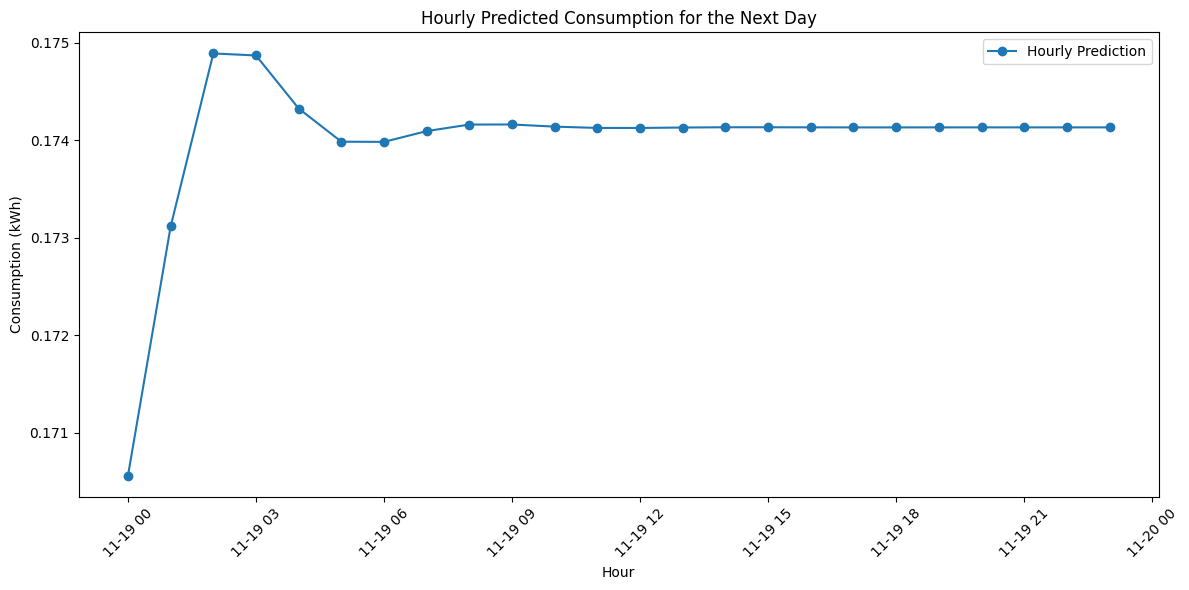

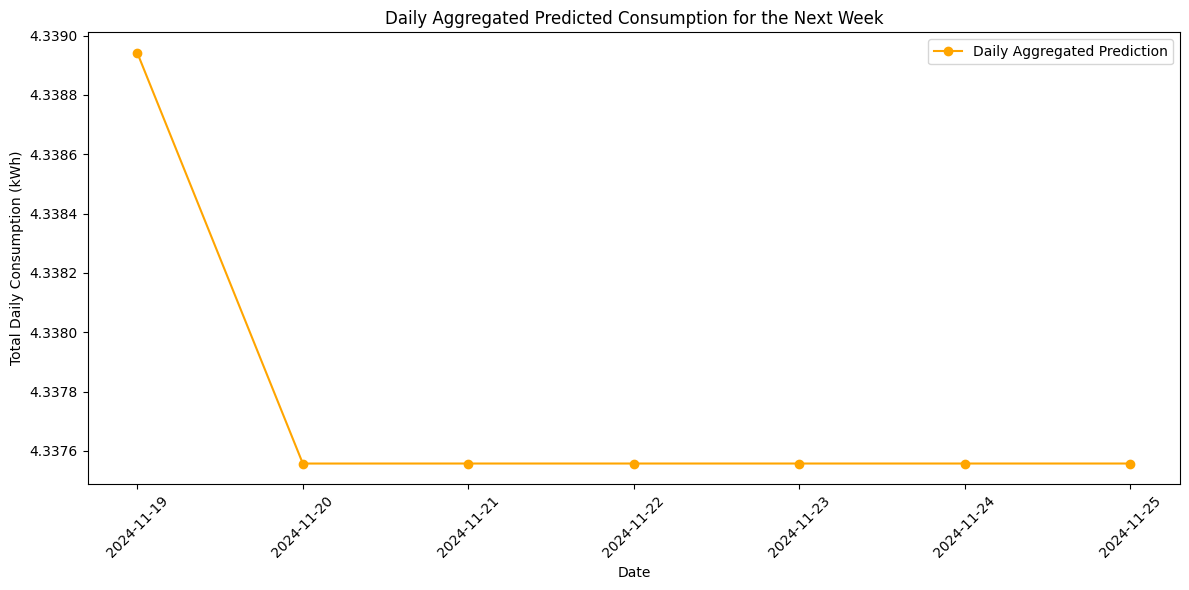

In [4]:
import pandas as pd
import numpy as np
import json
from datetime import timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings from ARIMA
warnings.filterwarnings("ignore")

# Load the dataset
data = pd.read_csv('.\Datasets\oneyear.csv')

# Convert 'timestamp' to datetime format for time-series data
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Set the 'timestamp' column as the index for time-series modeling
data.set_index('timestamp', inplace=True)

# Ensure 'unitConsumption' column is numeric; convert if necessary
data['unitConsumption'] = pd.to_numeric(data['unitConsumption'], errors='coerce')

# Handle missing values by forward filling
data.fillna(method='ffill', inplace=True)

# Predict hourly consumption for the next day (based on last 12 hours)
# Prepare the ARIMA model using the last 12 data points
last_12_hours = data['unitConsumption'][-12:]
model_hourly = ARIMA(last_12_hours, order=(3, 1, 0))  # ARIMA parameters tuned for short-term predictions
model_hourly_fit = model_hourly.fit()

# Generate hourly predictions for the next day (24 hours)
hourly_predictions = model_hourly_fit.forecast(steps=24)
hourly_timestamps = [data.index[-1] + timedelta(hours=i + 1) for i in range(24)]

# Prepare JSON for hourly predictions
hourly_output = [
    {
        "timestamp": str(hourly_timestamps[i]),  # Hourly timestamp
        "unitConsumption": float(hourly_predictions[i])  # Predicted consumption
    }
    for i in range(24)
]

with open('hourlyConsumption.json', 'w') as f:
    json.dump(hourly_output, f, indent=4)

# Predict weekly aggregated consumption (based on entire dataset)
model_weekly = ARIMA(data['unitConsumption'], order=(5, 1, 0))  # ARIMA parameters for long-term prediction
model_weekly_fit = model_weekly.fit()

# Generate predictions for the next week (7 days * 24 hours)
num_hours_week = 7 * 24
weekly_predictions = model_weekly_fit.forecast(steps=num_hours_week)
weekly_timestamps = [data.index[-1] + timedelta(hours=i + 1) for i in range(num_hours_week)]

# Aggregate weekly predictions
weekly_data = pd.DataFrame({
    "timestamp": weekly_timestamps,
    "unitConsumption": weekly_predictions
}).set_index('timestamp')

weekly_aggregated = weekly_data.resample('D').sum()  # Aggregate daily within the week

# Prepare JSON for weekly predictions
weekly_output = [
    {
        "date": str(day.date()),  # Daily date
        "totalConsumption": float(total)  # Total daily consumption
    }
    for day, total in weekly_aggregated['unitConsumption'].items()
]

with open('weeklyConsumption.json', 'w') as f:
    json.dump(weekly_output, f, indent=4)

# Print success messages
print("Hourly consumption predictions saved to hourlyConsumption.json")
print("Weekly consumption predictions saved to weeklyConsumption.json")

# Visualization
# Hourly predictions
plt.figure(figsize=(12, 6))
plt.plot(hourly_timestamps, hourly_predictions, label="Hourly Prediction", marker="o")
plt.xlabel("Hour")
plt.ylabel("Consumption (kWh)")
plt.title("Hourly Predicted Consumption for the Next Day")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Weekly predictions
plt.figure(figsize=(12, 6))
plt.plot(weekly_aggregated.index, weekly_aggregated['unitConsumption'], label="Daily Aggregated Prediction", marker="o", color="orange")
plt.xlabel("Date")
plt.ylabel("Total Daily Consumption (kWh)")
plt.title("Daily Aggregated Predicted Consumption for the Next Week")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


### After HyperParamter Tunning

Optimal ARIMA Parameters: (2, 0, 2) with AIC: -35490.59556657204


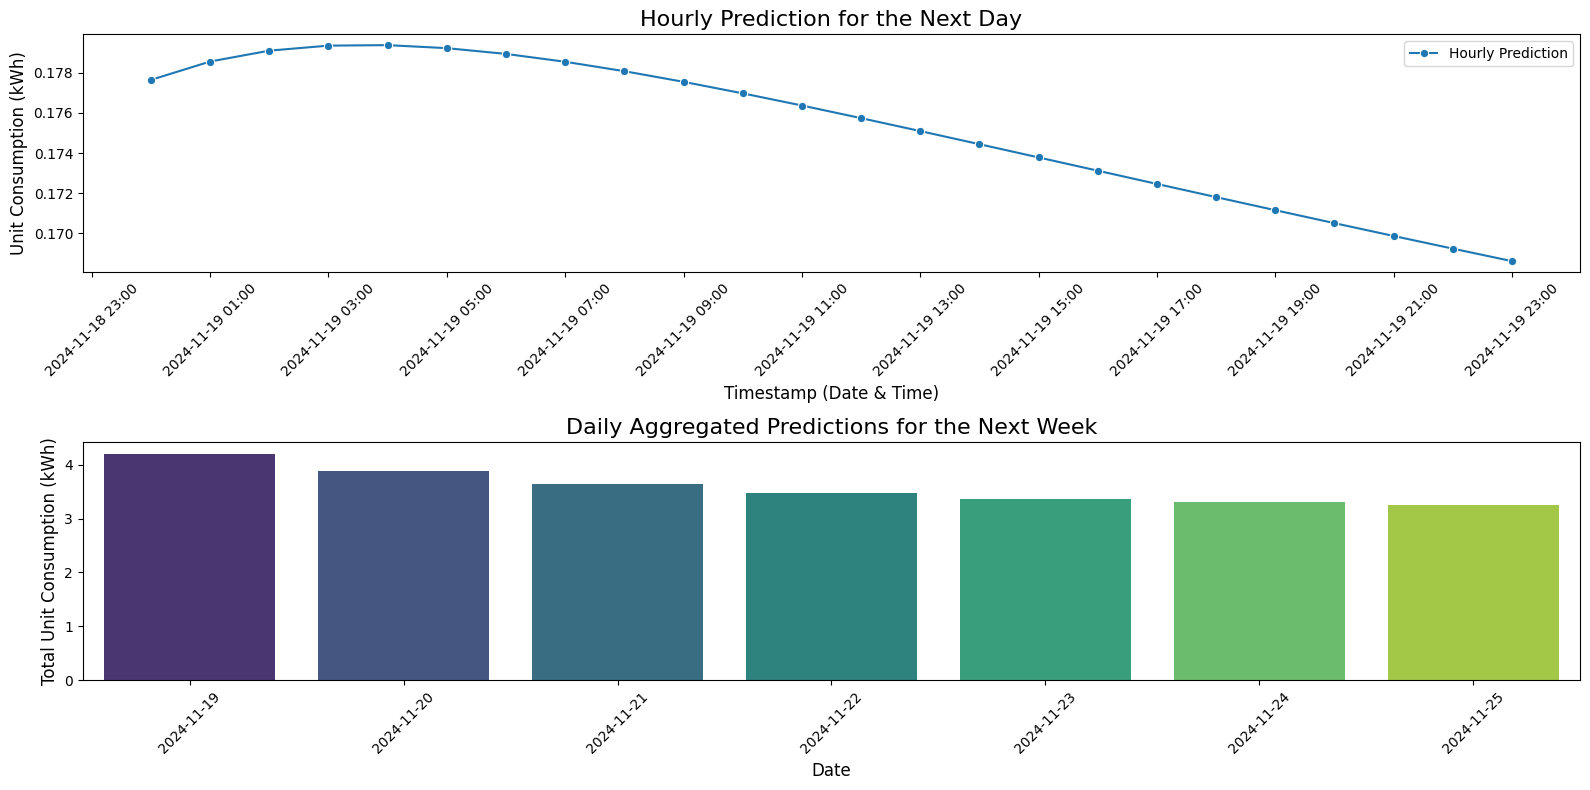

Daily predictions saved to dailyConsumption.json
Weekly predictions saved to weeklyConsumption.json


In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import itertools
import json
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Load the dataset
data = pd.read_csv('Datasets\oneyear.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Extract the target variable
data_series = data['unitConsumption']

# Define the range of parameters for tuning
p = range(0, 3)  # Autoregressive terms
d = range(0, 2)  # Differencing terms
q = range(0, 3)  # Moving average terms
pdq_combinations = list(itertools.product(p, d, q))

# Grid search for optimal (p, d, q)
best_aic = float('inf')
best_params = None
for params in pdq_combinations:
    try:
        model = ARIMA(data_series, order=params)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
    except:
        continue

print(f"Optimal ARIMA Parameters: {best_params} with AIC: {best_aic}")

# Train the optimized ARIMA model
optimal_model = ARIMA(data_series, order=best_params)
optimal_results = optimal_model.fit()

# Forecasting from the last timestamp of the dataset
last_date = data_series.index[-1]

# Forecast for the next 1 day (hourly) and 1 week
forecast_steps = 24  # 24 hours for 1 day
forecast_steps_week = 7 * 24  # 7 days with hourly data

# Generate predictions
forecast_daily = optimal_results.forecast(steps=forecast_steps)
forecast_weekly = optimal_results.forecast(steps=forecast_steps_week)

# Ensure forecast arrays are converted to lists
forecast_daily = forecast_daily.tolist()
forecast_weekly = forecast_weekly.tolist()

# Create timestamps for daily predictions
timestamps_daily = [last_date + timedelta(hours=i + 1) for i in range(forecast_steps)]
daily_output = [
    {"timestamp": str(timestamps_daily[i]), "unitConsumption": forecast_daily[i]}
    for i in range(forecast_steps)
]

# Save daily predictions to JSON
with open('dailyConsumption.json', 'w') as f:
    json.dump(daily_output, f, indent=4)

# Create timestamps for weekly predictions
timestamps_weekly = [last_date + timedelta(hours=i + 1) for i in range(forecast_steps_week)]

# Aggregate weekly predictions by days
forecast_weekly_df = pd.DataFrame({
    'timestamp': timestamps_weekly,
    'unitConsumption': forecast_weekly
})

# Extract the day from the timestamp
forecast_weekly_df['day'] = forecast_weekly_df['timestamp'].dt.date

# Aggregate by day to sum the `unitConsumption`
forecast_weekly_agg = forecast_weekly_df.groupby('day', as_index=False)['unitConsumption'].sum()

# Save weekly aggregated predictions to JSON
weekly_output = [
    {"day": str(row['day']), "unitConsumption": row['unitConsumption']}
    for _, row in forecast_weekly_agg.iterrows()
]

with open('weeklyConsumption.json', 'w') as f:
    json.dump(weekly_output, f, indent=4)


plt.figure(figsize=(16, 8))

# Daily predictions plot
plt.subplot(2, 1, 1)
sns.lineplot(x=timestamps_daily, y=forecast_daily, marker='o', label='Hourly Prediction')
plt.title('Hourly Prediction for the Next Day', fontsize=16)
plt.xlabel('Timestamp (Date & Time)', fontsize=12)
plt.ylabel('Unit Consumption (kWh)', fontsize=12)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Show ticks every 2 hours
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Weekly predictions plot
plt.subplot(2, 1, 2)
sns.barplot(x=forecast_weekly_agg['day'], y=forecast_weekly_agg['unitConsumption'], palette='viridis')
plt.title('Daily Aggregated Predictions for the Next Week', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Unit Consumption (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plots
plt.show()


# Print success messages
print("Daily predictions saved to dailyConsumption.json")
print("Weekly predictions saved to weeklyConsumption.json")



### Data preprocessing with ARIMA

Duplicate rows detected. Dropping duplicates.
Missing timestamps detected. Filling missing data with forward fill method.
Optimal ARIMA Parameters: (1, 1, 2) with AIC: -18982.355377116823


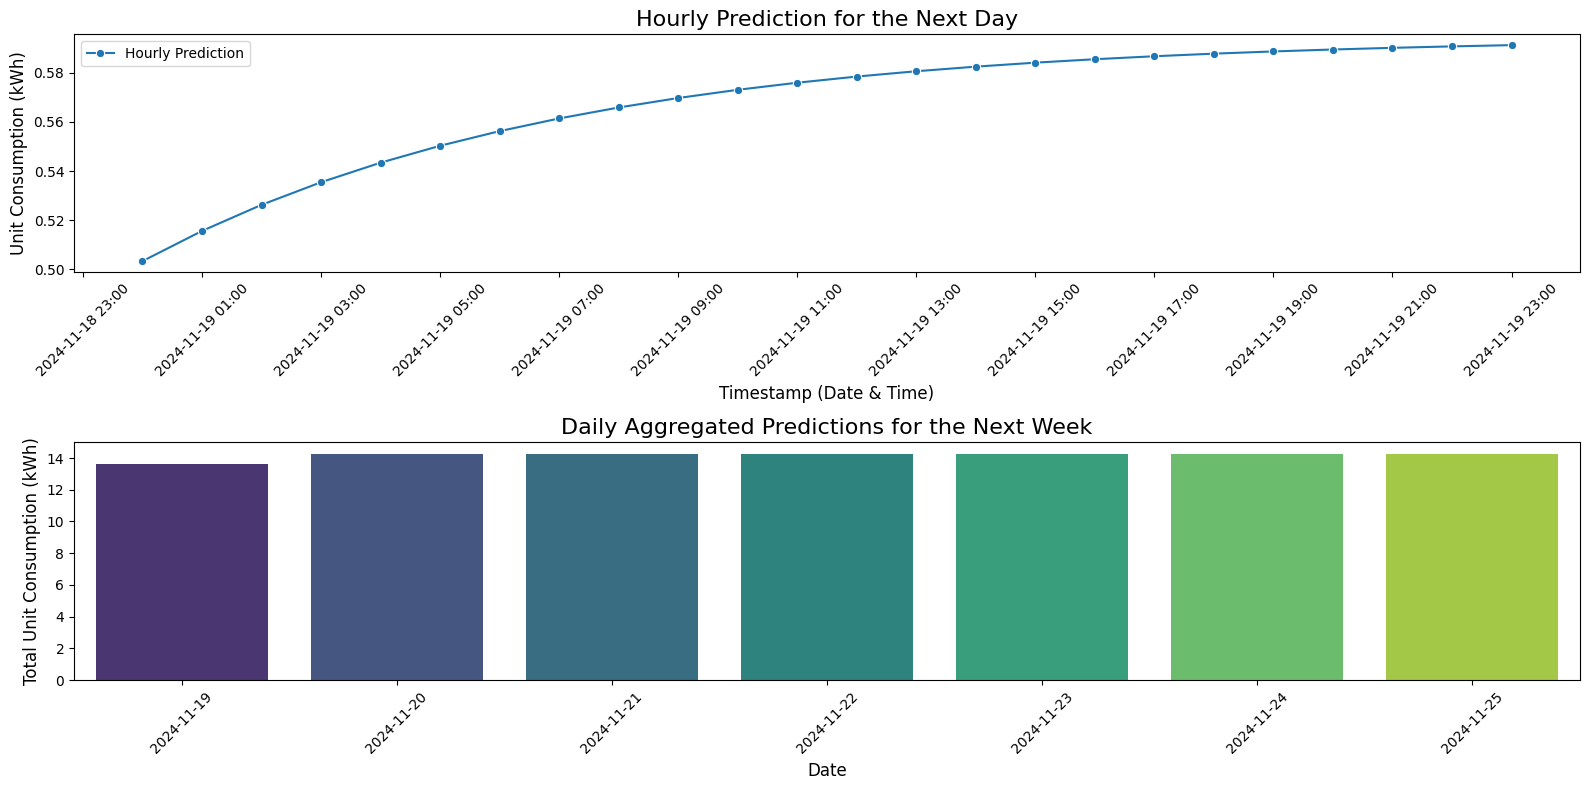

Daily predictions saved to dailyConsumption.json
Weekly predictions saved to weeklyConsumption.json


In [5]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import itertools
import json
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('Datasets/oneyear.csv')

# Data Cleaning and Preprocessing
# Convert 'timestamp' to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Check for missing values
if data.isnull().any().any():
    print("Missing values detected. Filling missing values with forward fill method.")
    data.fillna(method='ffill', inplace=True)  # Forward fill method
    # Alternatively, you could use backward fill: data.fillna(method='bfill', inplace=True)

# Check for duplicate rows
if data.duplicated().any():
    print("Duplicate rows detected. Dropping duplicates.")
    data.drop_duplicates(inplace=True)

# Outlier Detection and Handling (Z-score method)
z_scores = np.abs((data['unitConsumption'] - data['unitConsumption'].mean()) / data['unitConsumption'].std())
outliers = z_scores > 3  # Anything above 3 standard deviations is considered an outlier
data = data[~outliers]

# Ensure 'timestamp' is set as index
data.set_index('timestamp', inplace=True)

# Resample the data to ensure it's in hourly frequency (assuming data should be hourly)
data = data.resample('H').mean()  # Resampling to hourly data

# If there are missing timestamps due to resampling, fill them
if data.isnull().any().any():
    print("Missing timestamps detected. Filling missing data with forward fill method.")
    data.fillna(method='ffill', inplace=True)

# Normalize the 'unitConsumption' column using MinMaxScaler (optional)
scaler = MinMaxScaler(feature_range=(0, 1))
data['unitConsumption'] = scaler.fit_transform(data[['unitConsumption']])

# Extract the target variable
data_series = data['unitConsumption']

# Define the range of parameters for tuning
p = range(0, 3)  # Autoregressive terms
d = range(0, 2)  # Differencing terms
q = range(0, 3)  # Moving average terms
pdq_combinations = list(itertools.product(p, d, q))

# Grid search for optimal (p, d, q)
best_aic = float('inf')
best_params = None
for params in pdq_combinations:
    try:
        model = ARIMA(data_series, order=params)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = params
    except:
        continue

print(f"Optimal ARIMA Parameters: {best_params} with AIC: {best_aic}")

# Train the optimized ARIMA model
optimal_model = ARIMA(data_series, order=best_params)
optimal_results = optimal_model.fit()

# Forecasting from the last timestamp of the dataset
last_date = data_series.index[-1]

# Forecast for the next 1 day (hourly) and 1 week
forecast_steps = 24  # 24 hours for 1 day
forecast_steps_week = 7 * 24  # 7 days with hourly data

# Generate predictions
forecast_daily = optimal_results.forecast(steps=forecast_steps)
forecast_weekly = optimal_results.forecast(steps=forecast_steps_week)

# Ensure forecast arrays are converted to lists
forecast_daily = forecast_daily.tolist()
forecast_weekly = forecast_weekly.tolist()

# Create timestamps for daily predictions
timestamps_daily = [last_date + timedelta(hours=i + 1) for i in range(forecast_steps)]
daily_output = [
    {"timestamp": str(timestamps_daily[i]), "unitConsumption": forecast_daily[i]}
    for i in range(forecast_steps)
]

# Save daily predictions to JSON
with open('dailyConsumption.json', 'w') as f:
    json.dump(daily_output, f, indent=4)

# Create timestamps for weekly predictions
timestamps_weekly = [last_date + timedelta(hours=i + 1) for i in range(forecast_steps_week)]

# Aggregate weekly predictions by days
forecast_weekly_df = pd.DataFrame({
    'timestamp': timestamps_weekly,
    'unitConsumption': forecast_weekly
})

# Extract the day from the timestamp
forecast_weekly_df['day'] = forecast_weekly_df['timestamp'].dt.date

# Aggregate by day to sum the `unitConsumption`
forecast_weekly_agg = forecast_weekly_df.groupby('day', as_index=False)['unitConsumption'].sum()

# Save weekly aggregated predictions to JSON
weekly_output = [
    {"day": str(row['day']), "unitConsumption": row['unitConsumption']}
    for _, row in forecast_weekly_agg.iterrows()
]

with open('weeklyConsumption.json', 'w') as f:
    json.dump(weekly_output, f, indent=4)


plt.figure(figsize=(16, 8))

# Daily predictions plot
plt.subplot(2, 1, 1)
sns.lineplot(x=timestamps_daily, y=forecast_daily, marker='o', label='Hourly Prediction')
plt.title('Hourly Prediction for the Next Day', fontsize=16)
plt.xlabel('Timestamp (Date & Time)', fontsize=12)
plt.ylabel('Unit Consumption (kWh)', fontsize=12)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Show ticks every 2 hours
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Weekly predictions plot
plt.subplot(2, 1, 2)
sns.barplot(x=forecast_weekly_agg['day'], y=forecast_weekly_agg['unitConsumption'], palette='viridis')
plt.title('Daily Aggregated Predictions for the Next Week', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Unit Consumption (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plots
plt.show()


# Print success messages
print("Daily predictions saved to dailyConsumption.json")
print("Weekly predictions saved to weeklyConsumption.json")


### Dynamic prediction Using ARIMA


C:\Users\SEJAL\AppData\Local\Temp\ipykernel_17088\2216213093.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=forecast_weekly_agg['day'], y=forecast_weekly_agg['unitConsumption'], palette='viridis')


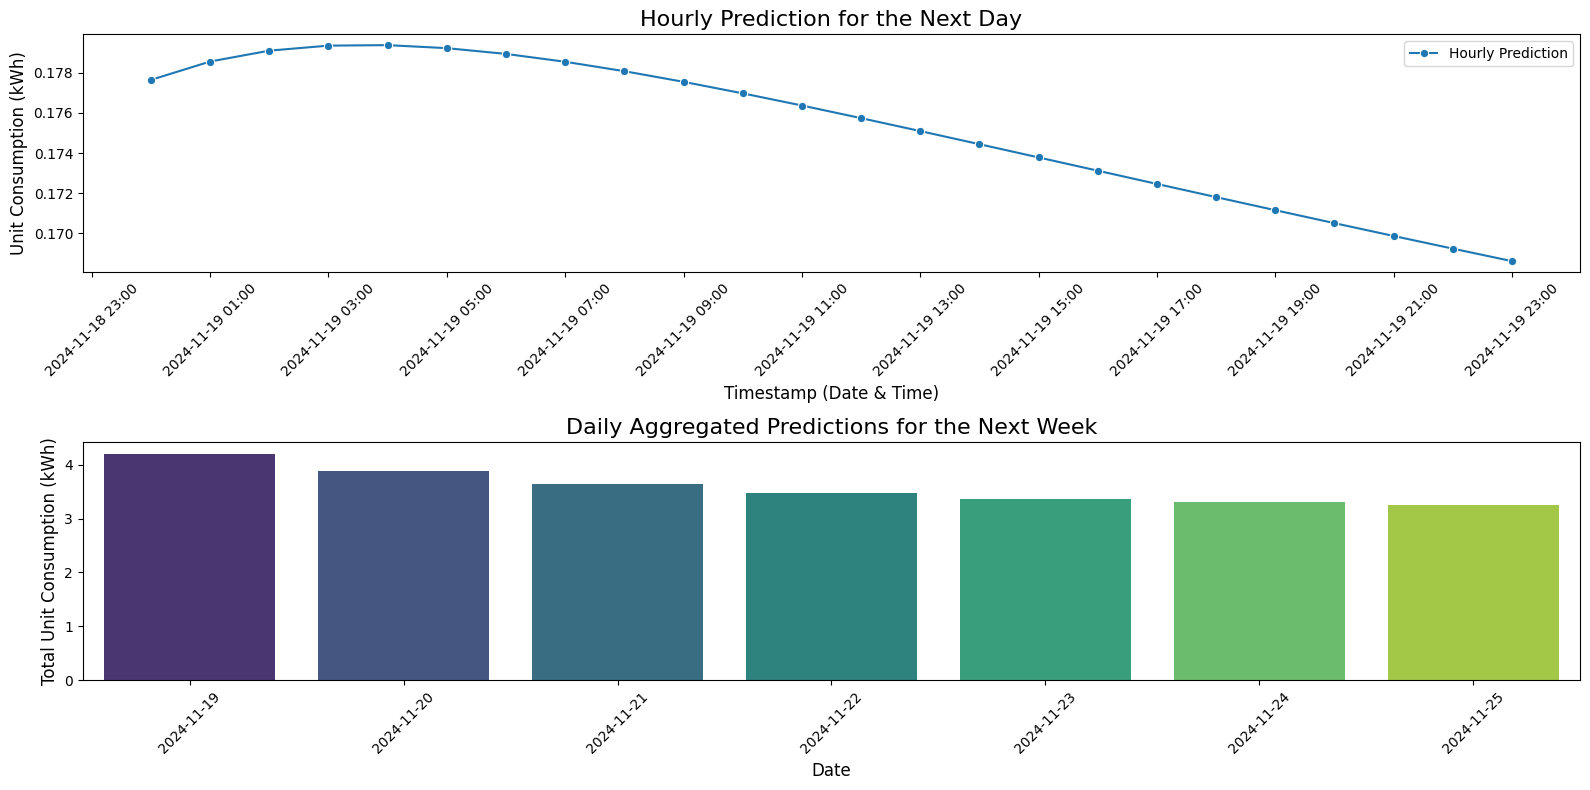

In [2]:
import matplotlib.dates as mdates

plt.figure(figsize=(16, 8))

# Daily predictions plot
plt.subplot(2, 1, 1)
sns.lineplot(x=timestamps_daily, y=forecast_daily, marker='o', label='Hourly Prediction')
plt.title('Hourly Prediction for the Next Day', fontsize=16)
plt.xlabel('Timestamp (Date & Time)', fontsize=12)
plt.ylabel('Unit Consumption (kWh)', fontsize=12)

# Format x-axis to show both date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Show ticks every 2 hours
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Weekly predictions plot
plt.subplot(2, 1, 2)
sns.barplot(x=forecast_weekly_agg['day'], y=forecast_weekly_agg['unitConsumption'], palette='viridis')
plt.title('Daily Aggregated Predictions for the Next Week', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Unit Consumption (kWh)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plots
plt.show()


### SARIMA for dynamic forecast

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Load the dataset
data = pd.read_csv('Datasets\October_2024_Energy_Consumption_kWh.csv')  # Replace with your dataset path
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Ensure the data is sorted
data = data.sort_index()

# Extract the target variable
data_series = data['unitConsumption']

# Determine the given month and calculate remaining days
given_month = data.index[0].month
days_in_month = pd.Timestamp(f'{data.index[0].year}-{given_month:02d}-01').days_in_month
days_provided = data.index[-1].day
days_remaining = days_in_month - days_provided

print(f"Days provided: {days_provided}, Days remaining: {days_remaining}")

# SARIMA model parameter tuning
from itertools import product

# Define parameter ranges for seasonal and non-seasonal components
p = d = q = range(0, 3)  # AR, Differencing, MA
P = D = Q = range(0, 3)  # Seasonal AR, Differencing, MA
m = 30  # Seasonal period (e.g., monthly patterns)

# Generate all combinations of parameters
non_seasonal_pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], m) for x in product(P, D, Q)]

best_aic = float('inf')
best_params = None

# Grid search for optimal parameters
for params in non_seasonal_pdq:
    for seasonal_params in seasonal_pdq:
        try:
            model = SARIMAX(data_series, order=params, seasonal_order=seasonal_params, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (params, seasonal_params)
        except:
            continue

print(f"Optimal SARIMA Parameters: {best_params} with AIC: {best_aic}")

# Train the SARIMA model with the optimal parameters
optimal_model = SARIMAX(data_series, 
                        order=best_params[0], 
                        seasonal_order=best_params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
results = optimal_model.fit(disp=False)

# Forecast for the remaining days
forecast_steps = days_remaining
forecast = results.forecast(steps=forecast_steps)

# Create timestamps for the remaining days
last_date = data.index[-1]
forecast_timestamps = [last_date + timedelta(days=i + 1) for i in range(forecast_steps)]

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({
    'timestamp': forecast_timestamps,
    'unitConsumption': forecast
})

# Plot the actual data and forecast
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y=data_series, label='Observed', marker='o')
sns.lineplot(x=forecast_df['timestamp'], y=forecast_df['unitConsumption'], label='Forecasted', marker='o')
plt.title('SARIMA Forecast for Remaining Days of the Month')
plt.xlabel('Date')
plt.ylabel('Unit Consumption')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Save forecast to a file
forecast_df.to_csv('sarima_forecast_remaining_month.csv', index=False)

print(f"Forecast saved to 'sarima_forecast_remaining_month.csv'")
